In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [38]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [50]:
PATH = os.path.join('images/')

BATCH_SIZE = 32
IMG_SIZE = (384, 384)
IMG_SHAPE = IMG_SIZE + (3,)

# Load the training dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

# Load the validation dataset
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

class_names = train_dataset.class_names
print(class_names)

# Configure the datasets for streaming (no caching)
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)


num_classes = 3

Found 4523 files belonging to 3 classes.
Using 3619 files for training.
Found 4523 files belonging to 3 classes.
Using 904 files for validation.
['moniliase', 'podridao-parda', 'saudavel']


In [41]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 20
Number of test batches: 4


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'), # Inverte a imagem aleatoriamente na horizontal (esquerda-direita).
    tf.keras.layers.RandomRotation(0.2), # Gira a imagem aleatoriamente em até 20% de 360 ​​graus.
    tf.keras.layers.RandomZoom(0.2), # Aumenta ou diminui o zoom aleatoriamente na imagem em até 20%.
    tf.keras.layers.RandomContrast(0.2), # Ajusta aleatoriamente o contraste da imagem em até 20%.
    tf.keras.layers.RandomBrightness(0.2), # Ajusta aleatoriamente o brilho da imagem em até 20%.
    tf.keras.layers.RandomTranslation(0.2, 0.2), # Desloca aleatoriamente a imagem horizontal e verticalmente em até 20%.
])

In [5]:
base_model = tf.keras.applications.EfficientNetV2S(input_shape=IMG_SHAPE,
                            include_top=False,
                            weights='imagenet',
                            include_preprocessing=True)

#For EfficientNetV2, by default input preprocessing is included as a part of the model (as a Rescaling layer), and thus keras.applications.efficientnet_v2.preprocess_input is actually a pass-through function.  
#https://keras.io/api/applications/efficientnet_v2/

In [6]:
#pooling: Optional pooling mode for feature extraction when include_top is False. Defaults to None.
#
#    None means that the output of the model will be the 4D tensor output of the last convolutional layer.
#    "avg" means that global average pooling will be applied to the output of the last convolutional layer, and thus the output of the model will be a 2D tensor.
#    "max" means that global max pooling will be applied.

In [7]:
base_model.trainable = False

In [8]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 384, 384, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 12, 12, 1280)   │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,843 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,342,891 (77.60 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 7,688 (30.04 KB)

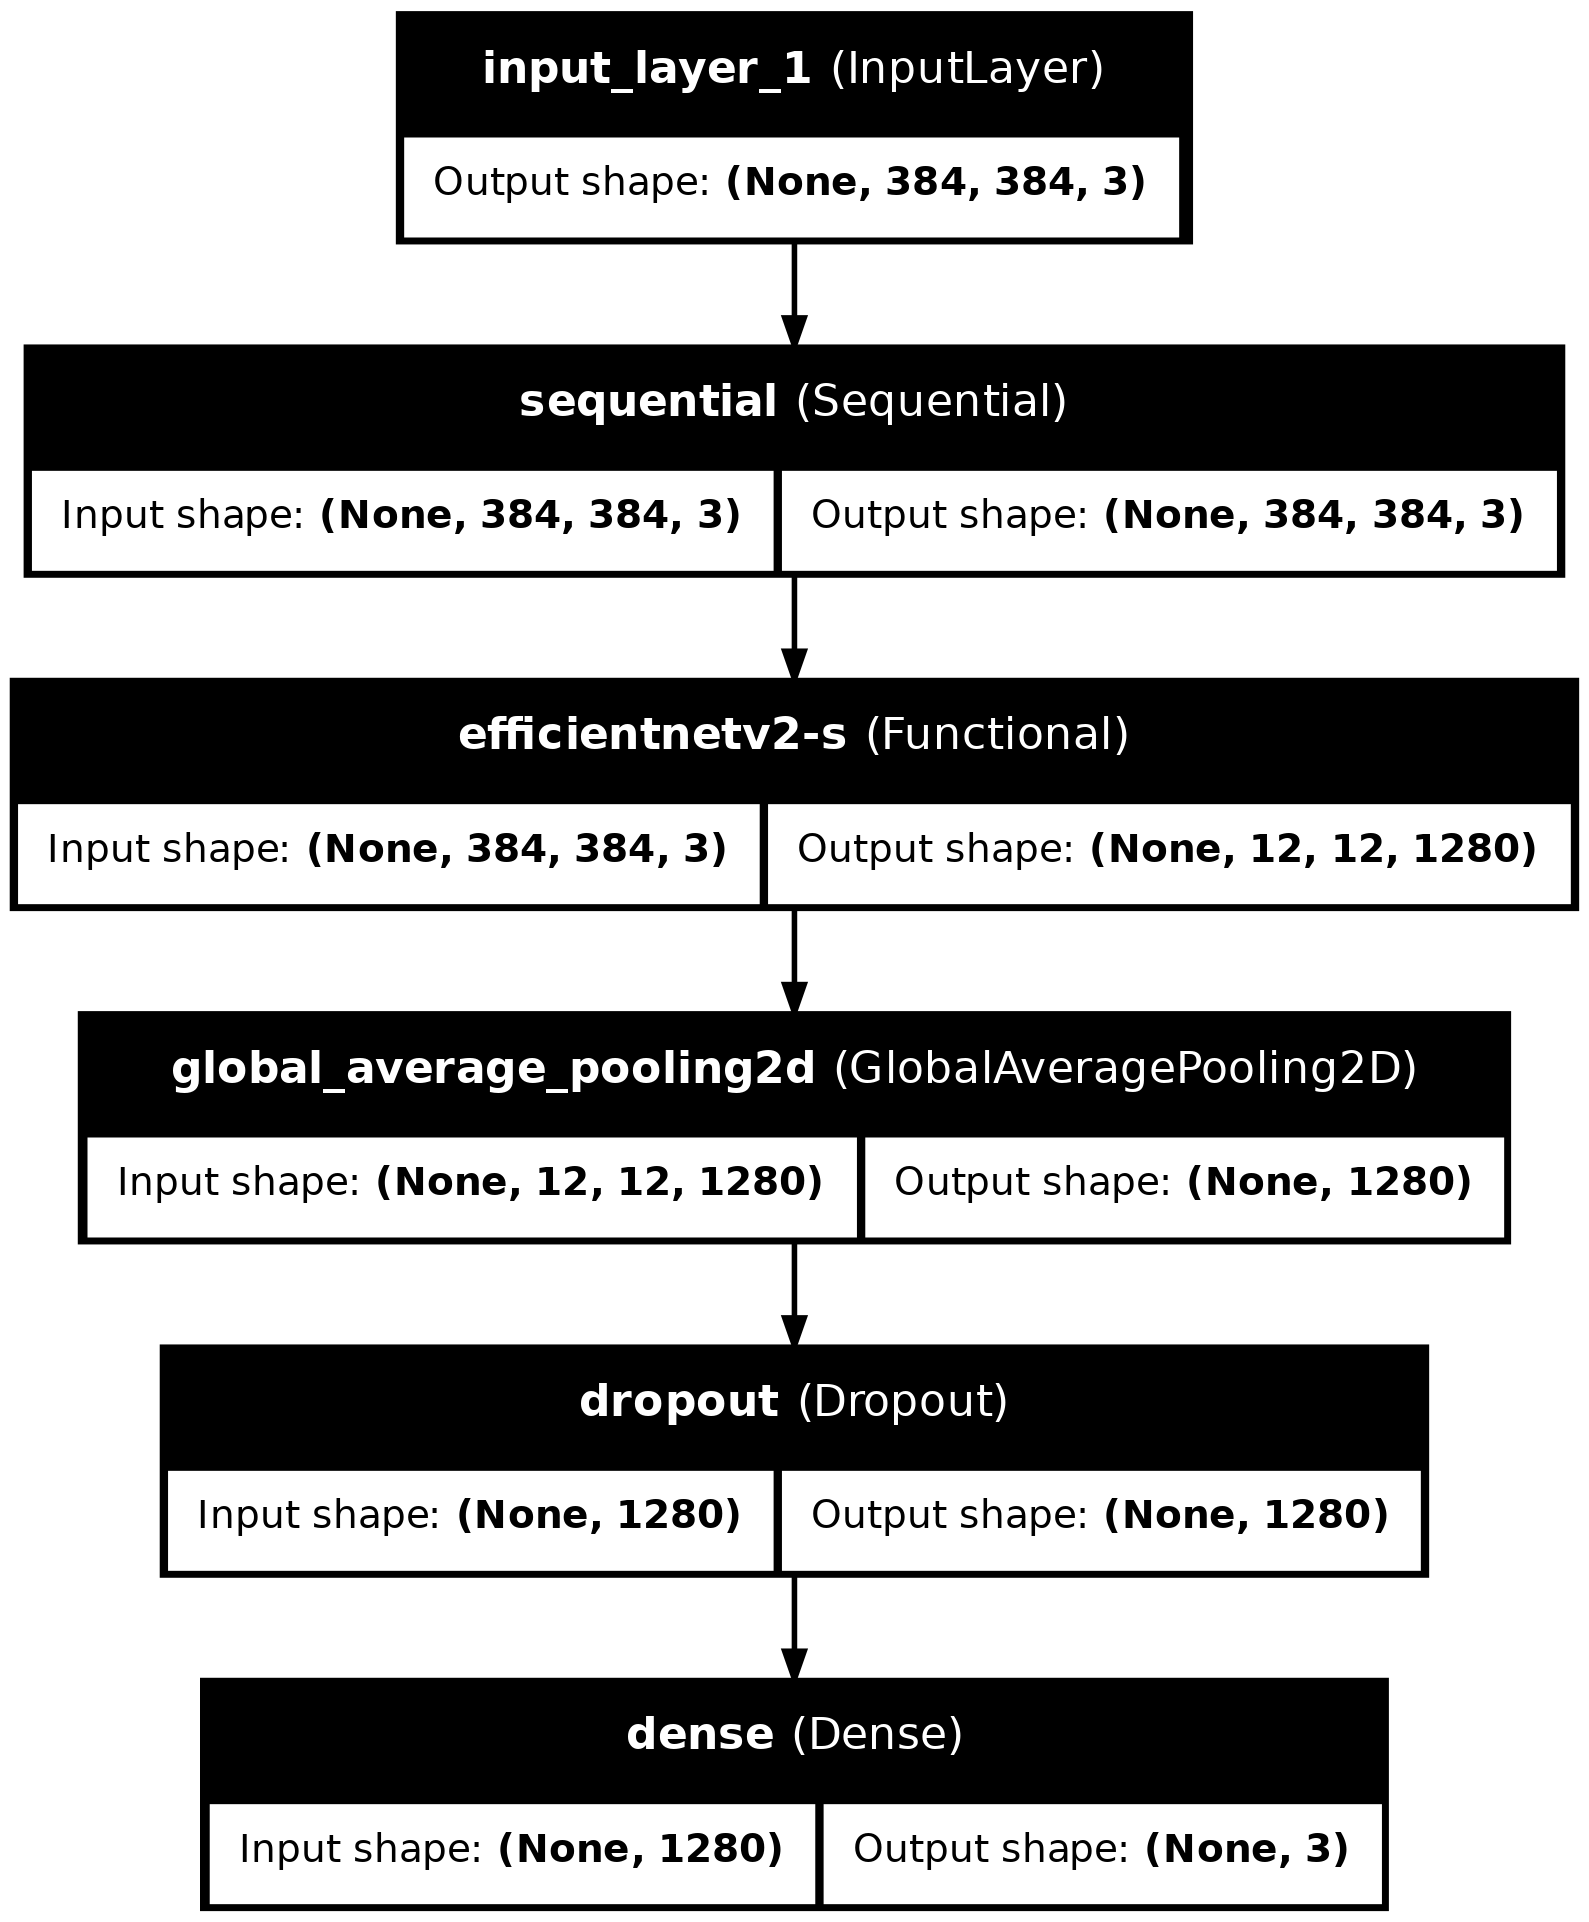

In [36]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [12]:
initial_epochs = 50
loss0, accuracy0 = model.evaluate(validation_dataset)

2024-08-10 15:43:51.417597: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1723315431.468853    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.481822    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.488424    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.500732    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.502381    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.504121    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.505707    9953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315431.507389    9953 gpu_t

28/29 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7175 - loss: 0.8382

W0000 00:00:1723315436.771499    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.772271    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.772965    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.773678    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.774305    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.774953    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.775911    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.776750    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.777579    9950 gp

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.7188 - loss: 0.8374


W0000 00:00:1723315436.972685    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.974046    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.975366    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.976828    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.978233    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.979571    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.981271    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.982754    9950 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315436.984694    9950 gp

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [16]:
callbacks = [
    early_stopping,
    reduce_lr,
    checkpoint,
]

In [17]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.6909 - loss: 0.8150

2024-08-10 15:44:14.362331: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 64/114 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.6944 - loss: 0.8060

2024-08-10 15:44:16.246661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:44:16.246705: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


113/114 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7073 - loss: 0.7734

W0000 00:00:1723315464.119241    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.119906    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.120513    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.121151    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.121709    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.122266    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.122885    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.123498    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.124140    9943 gp

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.7075 - loss: 0.7728

W0000 00:00:1723315464.320151    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.320847    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.321565    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.322217    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.322886    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.323542    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.324197    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.324874    9943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1723315464.325558    9943 gp

114/114 ━━━━━━━━━━━━━━━━━━━━ 33s 208ms/step - accuracy: 0.7077 - loss: 0.7723 - val_accuracy: 0.7588 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 2/50
 55/114 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.7493 - loss: 0.6435

2024-08-10 15:44:38.533096: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 72/114 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.7492 - loss: 0.6378

2024-08-10 15:44:41.198271: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:44:41.198554: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.7496 - loss: 0.6297 - val_accuracy: 0.7666 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 3/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7516 - loss: 0.5850

2024-08-10 15:45:00.461751: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.7530 - loss: 0.5815

2024-08-10 15:45:02.693712: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:45:02.693951: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.7571 - loss: 0.5733 - val_accuracy: 0.7754 - val_loss: 0.4990 - learning_rate: 1.0000e-04
Epoch 4/50
 53/114 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.7886 - loss: 0.5241

2024-08-10 15:45:24.051187: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7876 - loss: 0.5256

2024-08-10 15:45:26.430183: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:45:26.430492: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.7856 - loss: 0.5265 - val_accuracy: 0.7788 - val_loss: 0.4694 - learning_rate: 1.0000e-04
Epoch 5/50
 66/114 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7823 - loss: 0.5144

2024-08-10 15:45:49.062323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:45:49.062641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


 89/114 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.7846 - loss: 0.5100

2024-08-10 15:45:52.681595: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.7861 - loss: 0.5064 - val_accuracy: 0.8009 - val_loss: 0.4479 - learning_rate: 1.0000e-04
Epoch 6/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7952 - loss: 0.5049

2024-08-10 15:46:09.327785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.7955 - loss: 0.5016

2024-08-10 15:46:11.985205: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:46:11.985683: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 200ms/step - accuracy: 0.7982 - loss: 0.4930 - val_accuracy: 0.8119 - val_loss: 0.4302 - learning_rate: 1.0000e-04
Epoch 7/50
 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8018 - loss: 0.4777

2024-08-10 15:46:34.208501: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 86/114 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8053 - loss: 0.4723

2024-08-10 15:46:37.838703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:46:37.838955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8065 - loss: 0.4693 - val_accuracy: 0.8197 - val_loss: 0.4164 - learning_rate: 1.0000e-04
Epoch 8/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8072 - loss: 0.4723

2024-08-10 15:46:55.055801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 80/114 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8096 - loss: 0.4669

2024-08-10 15:46:59.912976: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:46:59.913186: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8106 - loss: 0.4630 - val_accuracy: 0.8230 - val_loss: 0.4044 - learning_rate: 1.0000e-04
Epoch 9/50
 66/114 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8123 - loss: 0.4562

2024-08-10 15:47:20.562336: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.8125 - loss: 0.4558

2024-08-10 15:47:20.879535: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:47:20.879780: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8164 - loss: 0.4477 - val_accuracy: 0.8308 - val_loss: 0.3940 - learning_rate: 1.0000e-04
Epoch 10/50
 56/114 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8283 - loss: 0.4157

2024-08-10 15:47:41.965485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8283 - loss: 0.4162

2024-08-10 15:47:43.679641: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:47:43.679680: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8293 - loss: 0.4157 - val_accuracy: 0.8396 - val_loss: 0.3859 - learning_rate: 1.0000e-04
Epoch 11/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8293 - loss: 0.4281

2024-08-10 15:48:04.203670: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8295 - loss: 0.4260

2024-08-10 15:48:06.095654: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:48:06.095783: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8285 - loss: 0.4200 - val_accuracy: 0.8407 - val_loss: 0.3780 - learning_rate: 1.0000e-04
Epoch 12/50
 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8242 - loss: 0.4130

2024-08-10 15:48:29.171005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-08-10 15:48:29.323379: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:48:29.323476: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8297 - loss: 0.4121 - val_accuracy: 0.8418 - val_loss: 0.3707 - learning_rate: 1.0000e-04
Epoch 13/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.8376 - loss: 0.3913

2024-08-10 15:48:50.428880: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 66/114 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8371 - loss: 0.3936

2024-08-10 15:48:52.944778: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:48:52.944998: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8383 - loss: 0.3939 - val_accuracy: 0.8507 - val_loss: 0.3640 - learning_rate: 1.0000e-04
Epoch 14/50
 59/114 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.8393 - loss: 0.4093

2024-08-10 15:49:14.769760: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 69/114 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.8401 - loss: 0.4077

2024-08-10 15:49:16.356514: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:49:16.356736: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8415 - loss: 0.4022 - val_accuracy: 0.8518 - val_loss: 0.3603 - learning_rate: 1.0000e-04
Epoch 15/50
 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.8521 - loss: 0.3834

2024-08-10 15:49:38.190974: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 81/114 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - accuracy: 0.8509 - loss: 0.3840

2024-08-10 15:49:41.239775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:49:41.240012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.8494 - loss: 0.3839 - val_accuracy: 0.8540 - val_loss: 0.3555 - learning_rate: 1.0000e-04
Epoch 16/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8531 - loss: 0.3838

2024-08-10 15:49:59.463034: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8516 - loss: 0.3847

2024-08-10 15:50:02.187819: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:50:02.187846: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step - accuracy: 0.8506 - loss: 0.3828 - val_accuracy: 0.8573 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 17/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8542 - loss: 0.3833

2024-08-10 15:50:22.991226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - accuracy: 0.8523 - loss: 0.3835

2024-08-10 15:50:25.145538: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:50:25.146045: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8509 - loss: 0.3817 - val_accuracy: 0.8584 - val_loss: 0.3471 - learning_rate: 1.0000e-04
Epoch 18/50
 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.8518 - loss: 0.3550

2024-08-10 15:50:48.092970: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 65/114 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8518 - loss: 0.3556

2024-08-10 15:50:48.577494: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:50:48.577564: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8517 - loss: 0.3636 - val_accuracy: 0.8595 - val_loss: 0.3428 - learning_rate: 1.0000e-04
Epoch 19/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.8525 - loss: 0.3790

2024-08-10 15:51:09.564274: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 62/114 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 0.8518 - loss: 0.3782

2024-08-10 15:51:11.909959: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:51:11.910011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.8520 - loss: 0.3742 - val_accuracy: 0.8628 - val_loss: 0.3383 - learning_rate: 1.0000e-04
Epoch 20/50
 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - accuracy: 0.8515 - loss: 0.3777

2024-08-10 15:51:36.260560: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:51:36.260629: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


 75/114 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.8517 - loss: 0.3754

2024-08-10 15:51:38.223110: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.8522 - loss: 0.3695 - val_accuracy: 0.8650 - val_loss: 0.3346 - learning_rate: 1.0000e-04
Epoch 21/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 164ms/step - accuracy: 0.8574 - loss: 0.3709

2024-08-10 15:51:58.062302: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 0.8574 - loss: 0.3699

2024-08-10 15:52:01.153440: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:52:01.153814: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.8574 - loss: 0.3655 - val_accuracy: 0.8650 - val_loss: 0.3323 - learning_rate: 1.0000e-04
Epoch 22/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.8502 - loss: 0.3671

2024-08-10 15:52:22.245481: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8503 - loss: 0.3661

2024-08-10 15:52:24.930277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:52:24.930496: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.8538 - loss: 0.3618 - val_accuracy: 0.8717 - val_loss: 0.3301 - learning_rate: 1.0000e-04
Epoch 23/50
 55/114 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step - accuracy: 0.8548 - loss: 0.3591 

2024-08-10 15:52:46.999862: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.8559 - loss: 0.3584

2024-08-10 15:52:48.904311: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:52:48.904550: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step - accuracy: 0.8575 - loss: 0.3555 - val_accuracy: 0.8706 - val_loss: 0.3261 - learning_rate: 1.0000e-04
Epoch 24/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.8397 - loss: 0.3914

2024-08-10 15:53:10.189634: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.8438 - loss: 0.3845

2024-08-10 15:53:13.110107: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:53:13.110149: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 220ms/step - accuracy: 0.8507 - loss: 0.3726 - val_accuracy: 0.8695 - val_loss: 0.3226 - learning_rate: 1.0000e-04
Epoch 25/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.8717 - loss: 0.3461 

2024-08-10 15:53:34.667989: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 64/114 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8702 - loss: 0.3474

2024-08-10 15:53:36.555206: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:53:36.555542: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - accuracy: 0.8679 - loss: 0.3478 - val_accuracy: 0.8739 - val_loss: 0.3211 - learning_rate: 1.0000e-04
Epoch 26/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8580 - loss: 0.3629

2024-08-10 15:53:57.804803: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8577 - loss: 0.3616

2024-08-10 15:54:00.303616: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:54:00.303827: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 205ms/step - accuracy: 0.8565 - loss: 0.3600 - val_accuracy: 0.8761 - val_loss: 0.3175 - learning_rate: 1.0000e-04
Epoch 27/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8556 - loss: 0.3480

2024-08-10 15:54:21.274738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 0.8559 - loss: 0.3485

2024-08-10 15:54:23.572738: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:54:23.576477: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.8584 - loss: 0.3452 - val_accuracy: 0.8816 - val_loss: 0.3162 - learning_rate: 1.0000e-04
Epoch 28/50
 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.8471 - loss: 0.3741

2024-08-10 15:54:48.402890: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 71/114 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8481 - loss: 0.3722

2024-08-10 15:54:49.049122: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:54:49.049198: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.8549 - loss: 0.3613 - val_accuracy: 0.8794 - val_loss: 0.3140 - learning_rate: 1.0000e-04
Epoch 29/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 0.8667 - loss: 0.3374

2024-08-10 15:55:10.500522: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 70/114 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8670 - loss: 0.3369

2024-08-10 15:55:13.839330: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:55:13.841396: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 215ms/step - accuracy: 0.8680 - loss: 0.3344 - val_accuracy: 0.8783 - val_loss: 0.3104 - learning_rate: 1.0000e-04
Epoch 30/50
 49/114 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8601 - loss: 0.3417

2024-08-10 15:55:34.545434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 73/114 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 0.8592 - loss: 0.3423

2024-08-10 15:55:38.326223: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:55:38.326403: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.8602 - loss: 0.3400 - val_accuracy: 0.8794 - val_loss: 0.3086 - learning_rate: 1.0000e-04
Epoch 31/50
 65/114 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.8696 - loss: 0.3489

2024-08-10 15:56:01.579184: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:56:01.579671: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


 74/114 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.8702 - loss: 0.3470

2024-08-10 15:56:03.134097: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.8722 - loss: 0.3419 - val_accuracy: 0.8794 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 32/50
 67/114 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.8814 - loss: 0.3406

2024-08-10 15:56:26.614323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-08-10 15:56:26.775635: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:56:26.775702: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 26s 224ms/step - accuracy: 0.8803 - loss: 0.3356 - val_accuracy: 0.8827 - val_loss: 0.3052 - learning_rate: 1.0000e-04
Epoch 33/50
 54/114 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.8650 - loss: 0.3591

2024-08-10 15:56:49.525459: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 0.8644 - loss: 0.3565

2024-08-10 15:56:50.967892: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:56:50.968210: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.8642 - loss: 0.3471 - val_accuracy: 0.8861 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 34/50
 48/114 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8558 - loss: 0.3399

2024-08-10 15:57:12.296008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 80/114 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.8591 - loss: 0.3360

2024-08-10 15:57:17.422203: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:57:17.422478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8607 - loss: 0.3343 - val_accuracy: 0.8850 - val_loss: 0.3015 - learning_rate: 1.0000e-04
Epoch 35/50
 48/114 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8634 - loss: 0.3618

2024-08-10 15:57:35.552053: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.8656 - loss: 0.3563

2024-08-10 15:57:38.664342: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:57:38.664785: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8694 - loss: 0.3458 - val_accuracy: 0.8861 - val_loss: 0.2992 - learning_rate: 1.0000e-04
Epoch 36/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 9s 157ms/step - accuracy: 0.8787 - loss: 0.3266

2024-08-10 15:57:59.303824: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 84/114 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8794 - loss: 0.3261

2024-08-10 15:58:04.372452: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:58:04.372801: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 201ms/step - accuracy: 0.8789 - loss: 0.3264 - val_accuracy: 0.8861 - val_loss: 0.2983 - learning_rate: 1.0000e-04
Epoch 37/50
 65/114 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 0.8741 - loss: 0.3335

2024-08-10 15:58:25.288420: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:58:25.288490: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


 72/114 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.8742 - loss: 0.3324

2024-08-10 15:58:26.472006: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 223ms/step - accuracy: 0.8737 - loss: 0.3279 - val_accuracy: 0.8883 - val_loss: 0.2976 - learning_rate: 1.0000e-04
Epoch 38/50
 53/114 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - accuracy: 0.8571 - loss: 0.3473

2024-08-10 15:58:48.896655: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.8597 - loss: 0.3446

2024-08-10 15:58:51.539659: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:58:51.540058: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 221ms/step - accuracy: 0.8634 - loss: 0.3405 - val_accuracy: 0.8894 - val_loss: 0.2958 - learning_rate: 1.0000e-04
Epoch 39/50
 53/114 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8650 - loss: 0.3490

2024-08-10 15:59:13.577611: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 76/114 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.8674 - loss: 0.3417

2024-08-10 15:59:17.713084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:59:17.713144: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.8696 - loss: 0.3360 - val_accuracy: 0.8850 - val_loss: 0.2953 - learning_rate: 1.0000e-04
Epoch 40/50
 58/114 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8792 - loss: 0.3088

2024-08-10 15:59:38.920732: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 65/114 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - accuracy: 0.8783 - loss: 0.3097

2024-08-10 15:59:40.102455: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 15:59:40.102727: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.8762 - loss: 0.3116 - val_accuracy: 0.8850 - val_loss: 0.2940 - learning_rate: 1.0000e-04
Epoch 41/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8676 - loss: 0.3455

2024-08-10 16:00:02.626931: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 78/114 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.8720 - loss: 0.3385

2024-08-10 16:00:07.104883: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:00:07.105469: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.8749 - loss: 0.3324 - val_accuracy: 0.8827 - val_loss: 0.2930 - learning_rate: 1.0000e-04
Epoch 42/50
 51/114 ━━━━━━━━━━━━━━━━━━━━ 11s 176ms/step - accuracy: 0.8723 - loss: 0.3280

2024-08-10 16:00:26.877826: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 72/114 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.8738 - loss: 0.3246

2024-08-10 16:00:30.389012: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:00:30.389261: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.8752 - loss: 0.3217 - val_accuracy: 0.8861 - val_loss: 0.2913 - learning_rate: 1.0000e-04
Epoch 43/50
 50/114 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - accuracy: 0.8644 - loss: 0.3449

2024-08-10 16:00:51.299299: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.8654 - loss: 0.3412

2024-08-10 16:00:54.061347: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:00:54.061867: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 213ms/step - accuracy: 0.8679 - loss: 0.3335 - val_accuracy: 0.8861 - val_loss: 0.2898 - learning_rate: 1.0000e-04
Epoch 44/50
 48/114 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - accuracy: 0.8698 - loss: 0.3348

2024-08-10 16:01:14.867967: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 68/114 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8706 - loss: 0.3354

2024-08-10 16:01:18.065939: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:01:18.066005: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8733 - loss: 0.3300 - val_accuracy: 0.8938 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 45/50
 52/114 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.8766 - loss: 0.3255 

2024-08-10 16:01:38.818536: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 73/114 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8781 - loss: 0.3208

2024-08-10 16:01:42.123779: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:01:42.124181: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8784 - loss: 0.3162 - val_accuracy: 0.8938 - val_loss: 0.2865 - learning_rate: 1.0000e-04
Epoch 46/50
 57/114 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8687 - loss: 0.3178

2024-08-10 16:02:02.793678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 67/114 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.8689 - loss: 0.3182

2024-08-10 16:02:04.390008: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:02:04.390049: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.8704 - loss: 0.3171 - val_accuracy: 0.8993 - val_loss: 0.2855 - learning_rate: 1.0000e-04
Epoch 47/50
 55/114 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.8786 - loss: 0.3183

2024-08-10 16:02:25.983579: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 74/114 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.8797 - loss: 0.3155

2024-08-10 16:02:29.004478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:02:29.005178: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.8797 - loss: 0.3125 - val_accuracy: 0.8982 - val_loss: 0.2848 - learning_rate: 1.0000e-04
Epoch 48/50
 60/114 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8864 - loss: 0.2973

2024-08-10 16:02:50.007306: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 70/114 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8857 - loss: 0.2985

2024-08-10 16:02:51.587796: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:02:51.587903: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - accuracy: 0.8840 - loss: 0.3010 - val_accuracy: 0.8982 - val_loss: 0.2829 - learning_rate: 1.0000e-04
Epoch 49/50
 61/114 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8761 - loss: 0.3177

2024-08-10 16:03:13.582084: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


 79/114 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.8771 - loss: 0.3151

2024-08-10 16:03:16.464861: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:03:16.464930: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8783 - loss: 0.3127 - val_accuracy: 0.8960 - val_loss: 0.2835 - learning_rate: 1.0000e-04
Epoch 50/50
 63/114 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.8698 - loss: 0.3228

2024-08-10 16:03:35.843300: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
2024-08-10 16:03:35.853162: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC PROFILE': C806007Ch: exceeds application limits
2024-08-10 16:03:35.853202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: CRC error


114/114 ━━━━━━━━━━━━━━━━━━━━ 23s 203ms/step - accuracy: 0.8730 - loss: 0.3199 - val_accuracy: 0.8938 - val_loss: 0.2820 - learning_rate: 1.0000e-04


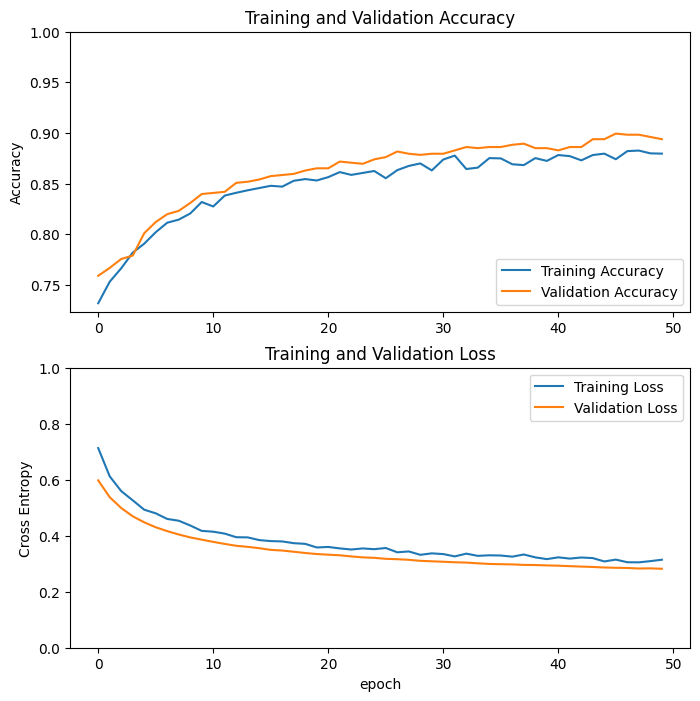

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

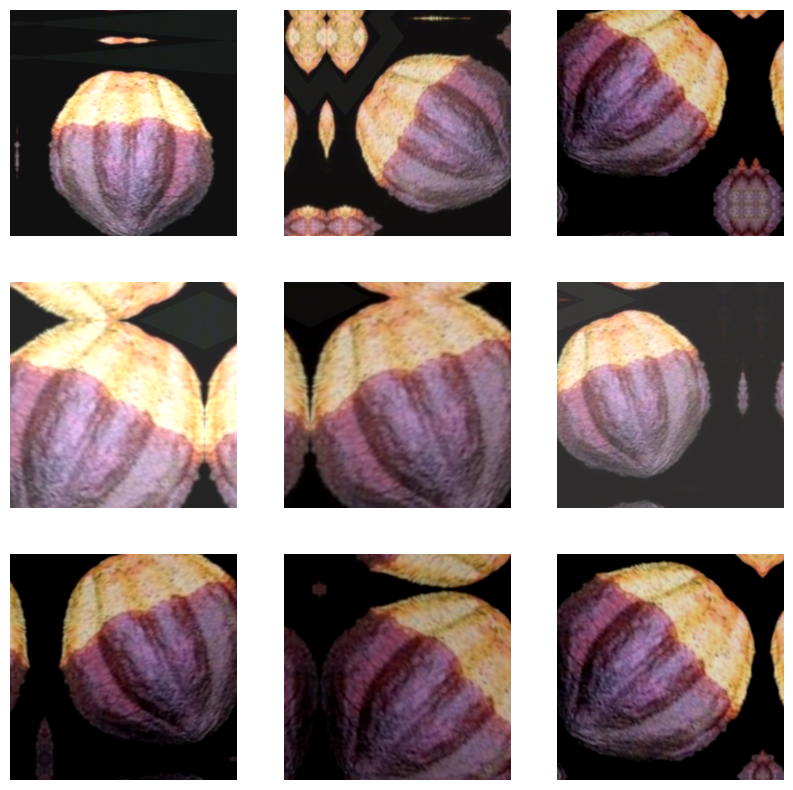

In [25]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.9042 - loss: 0.2958
Test accuracy : 0.8984375


Predictions:
 [0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0
 1 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1]
Labels:
 [1 2 2 2 1 2 2 1 2 0 1 2 2 2 2 2 2 2 2 1 2 1 2 1 2 1 2 1 2 2 1 1]


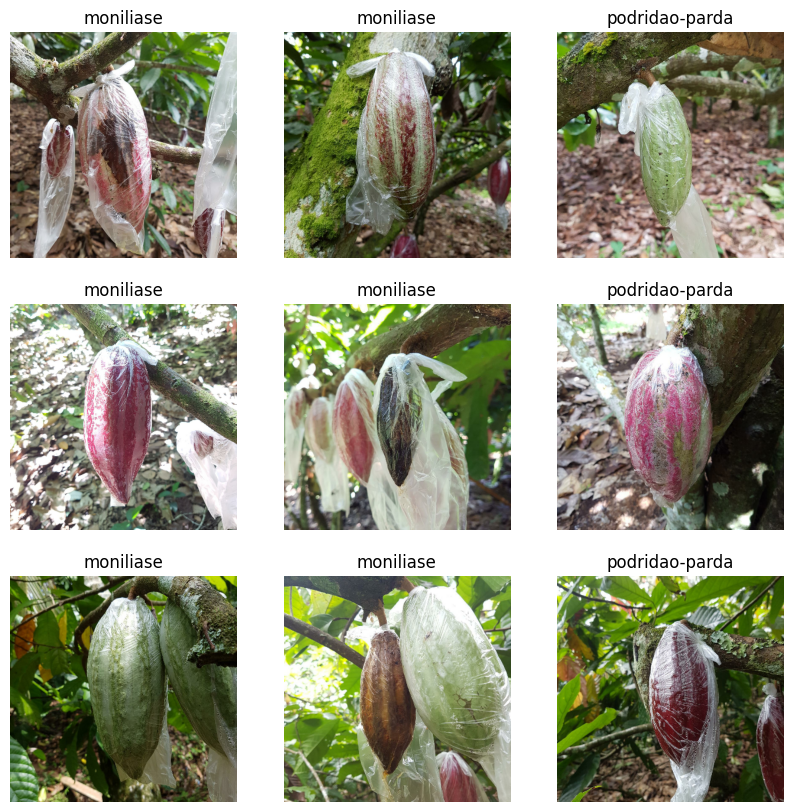

In [54]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")